Natalia Sofía Guevara Hernández A00835884

In [162]:
import json
import requests
import os
import zipfile
import geopandas as gpd
import pandas as pd
import contextily as cx
import numpy as np
import io
from pandas import json_normalize
from sklearn.cluster import MeanShift, estimate_bandwidth, get_bin_seeds
from sklearn.preprocessing import MinMaxScaler

# CLUSTERING POR RESTAURANTES

El objetivo principal de este proyecto es lograr dar recomendaciones de posibles ubicaciones para abrir restaurantes de cierto giro.
El primer para conseguir esto es usar K-means para agrupar los AGEBs en clusters, utilizando datos de frecuencia de restaurantes. Estos clusters serviránpara identificar patrones y similitudes entre diferentes áreas en términos de la disponibilidad y variedad de restaurantes.

In [163]:
#leemos el archicvo shape de los agebs de Nuevo León
gdf = gpd.read_file("DF_FINAL.shp").to_crs(4326)

In [164]:
gdf.head()

,CVEMA,MUN,NOM_MUN,AGEB,P12A14NOA,P15YM_AN,P18YM_PB,P6A11_NOAM,POBTOT,PSINDER,...,VPH_REFRI,VPH_TELEF,Restaurant,Restaura_1,Restaura_2,Restaura_3,Restaura_4,Restaura_5,Restaura_6,geometry
0,0061882,6,Apodaca,1882,10,67,3404,0,10712,2186,...,2786,1874,0,2,0,3,3,1,3,"POLYGON ((-100.15091 25.71505, -100.15099 25.7..."
1,0061435,6,Apodaca,1435,5,16,4582,4,9224,1185,...,2538,1712,0,0,0,1,1,3,0,"POLYGON ((-100.16946 25.75323, -100.16861 25.7..."
2,0061647,6,Apodaca,1647,3,6,2822,0,4650,638,...,1404,1128,0,0,0,2,1,0,0,"POLYGON ((-100.23345 25.77729, -100.23349 25.7..."
3,0060969,6,Apodaca,0969,0,0,0,0,0,0,...,0,0,8,2,1,3,3,6,0,"POLYGON ((-100.18562 25.77552, -100.18542 25.7..."
4,006030A,6,Apodaca,030A,10,15,2860,7,8268,1230,...,2168,1343,0,1,0,1,0,0,0,"POLYGON ((-100.16562 25.73954, -100.16554 25.7..."


In [165]:
nuevos_nombres = {'Restaurant': 'Rest_Carta',
                  'Restaura_1': 'Rest_Antojitos',
                  'Restaura_2': 'Rest_Mariscos',
                  'Restaura_3': 'Rest_Rapida',
                  'Restaura_4': 'Rest_TacosTortas',
                  'Restaura_5': 'Rest_Autoserv',
                  'Restaura_6': 'Rest_OtrosLlevar',
                  }

gdf.rename(columns=nuevos_nombres, inplace=True)
gdf.head()


,CVEMA,MUN,NOM_MUN,AGEB,P12A14NOA,P15YM_AN,P18YM_PB,P6A11_NOAM,POBTOT,PSINDER,...,VPH_REFRI,VPH_TELEF,Rest_Carta,Rest_Antojitos,Rest_Mariscos,Rest_Rapida,Rest_TacosTortas,Rest_Autoserv,Rest_OtrosLlevar,geometry
0,0061882,6,Apodaca,1882,10,67,3404,0,10712,2186,...,2786,1874,0,2,0,3,3,1,3,"POLYGON ((-100.15091 25.71505, -100.15099 25.7..."
1,0061435,6,Apodaca,1435,5,16,4582,4,9224,1185,...,2538,1712,0,0,0,1,1,3,0,"POLYGON ((-100.16946 25.75323, -100.16861 25.7..."
2,0061647,6,Apodaca,1647,3,6,2822,0,4650,638,...,1404,1128,0,0,0,2,1,0,0,"POLYGON ((-100.23345 25.77729, -100.23349 25.7..."
3,0060969,6,Apodaca,0969,0,0,0,0,0,0,...,0,0,8,2,1,3,3,6,0,"POLYGON ((-100.18562 25.77552, -100.18542 25.7..."
4,006030A,6,Apodaca,030A,10,15,2860,7,8268,1230,...,2168,1343,0,1,0,1,0,0,0,"POLYGON ((-100.16562 25.73954, -100.16554 25.7..."


In [166]:
# columnas relevantes para el clustering
columnas_clustering = ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar',
                       'POBTOT'
                       ]

# creo dataframe solo con las colmnas seleccionadas
datos_clustering = gdf[columnas_clustering]


In [167]:
datos_clustering

,Rest_Carta,Rest_Antojitos,Rest_Mariscos,Rest_Rapida,Rest_TacosTortas,Rest_Autoserv,Rest_OtrosLlevar,POBTOT
0,0,2,0,3,3,1,3,10712
1,0,0,0,1,1,3,0,9224
2,0,0,0,2,1,0,0,4650
3,8,2,1,3,3,6,0,0
4,0,1,0,1,0,0,0,8268
...,...,...,...,...,...,...,...,...
1282,1,2,0,2,3,1,1,6710
1283,0,1,0,2,2,0,0,4866
1284,0,0,0,0,1,0,0,0
1285,0,1,0,0,0,0,0,5766


Debido a que las variables de frecuencia de restaurantes pueden tener diferentes escalas y magnitudes, la normalización garantiza que todas las variables contribuyan equitativamente al cálculo de la distancia entre puntos. Es por esto que se normalizan los datos para entrenar el modelo:

In [168]:
# Normalizamos los datos
scaler = MinMaxScaler()
datos_normalizados = scaler.fit_transform(datos_clustering, columnas_clustering)

Se hace una primera prueba del modelo.

In [169]:
shiftProm = MeanShift().fit(datos_normalizados)

In [170]:
estimate_bandwidth(datos_normalizados)

0.2813464798026591

In [171]:
gdf['Cluster'] = shiftProm.labels_
print(gdf['Cluster'].value_counts())

Cluster
0     1120
13      40
1       24
2       22
4       19
23      16
22      11
17       7
3        4
12       4
5        4
19       2
18       2
6        2
16       1
14       1
15       1
9        1
21       1
11       1
8        1
7        1
20       1
10       1
Name: count, dtype: int64


Calculamos el coeficiente de la silueta para revisar que tan similares son los datos de un cluster en comparación de otros clusters.

In [172]:
from sklearn.metrics import silhouette_score
silhouette_score(datos_normalizados, shiftProm.labels_)

0.28928398937875416

#### Prueba con diferentes valores en los parámetros.

In [173]:
semillas1 = get_bin_seeds(datos_normalizados, bin_size=0.2813464798026591)
semillas2 = get_bin_seeds(datos_normalizados, bin_size=0.5)
semillas3 = get_bin_seeds(datos_normalizados, bin_size=0.8)

In [174]:
# Definir hiperparámetros a variar
seeds_options = [semillas1, semillas2, semillas3]

# Crear una lista para almacenar temporalmente los resultados
resultados_list = []

# Iterar sobre todas las combinaciones de hiperparámetros
for s in seeds_options:
    # Crear y entrenar el modelo de KMeans
    means = MeanShift(bandwidth=0.2813464798026591, seeds=s).fit(datos_normalizados)
    sil_coef = silhouette_score(datos_normalizados, means.labels_)

    # Guardar las etiquetas de los clusters en la lista de resultados
    resultados_list.append({'Bandwith': 0.2813464798026591,
                            'Seeds': s,
                            'Cluster_Labels': means.labels_,
                            'Silhoutte_Coef': sil_coef})

# Convertir la lista de resultados en un DataFrame
resultados_df = pd.DataFrame(resultados_list)

# Visualización de los resultados
print(resultados_df)  # Verificar el DataFrame de resultados

   Bandwith                                              Seeds  \
0  0.281346  [[0.0, 0.28134647, 0.0, 0.28134647, 0.0, 0.0, ...   
1  0.281346  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5], [0....   
2  0.281346  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8], [0....   

                                      Cluster_Labels  Silhoutte_Coef  
0  [0, 0, 0, 1, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0,...        0.292419  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        0.392939  
2  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        0.570050  


Ya que la combinación de un ancho de banda de 0.2813464798026591 y las semillas hechas con un bin_size igual a 0.8 es la que tiene un coeficiente de silueta más alto son los parámetros que se utilizaran.

In [199]:
silhouette_scores = []
for index, row in resultados_df.iterrows():
    means2 = MeanShift(bandwidth=row['Bandwith'], seeds=row['Seeds'])
    means2.fit(datos_normalizados)
    silhouette_scores.append(silhouette_score(datos_normalizados, means2.labels_))

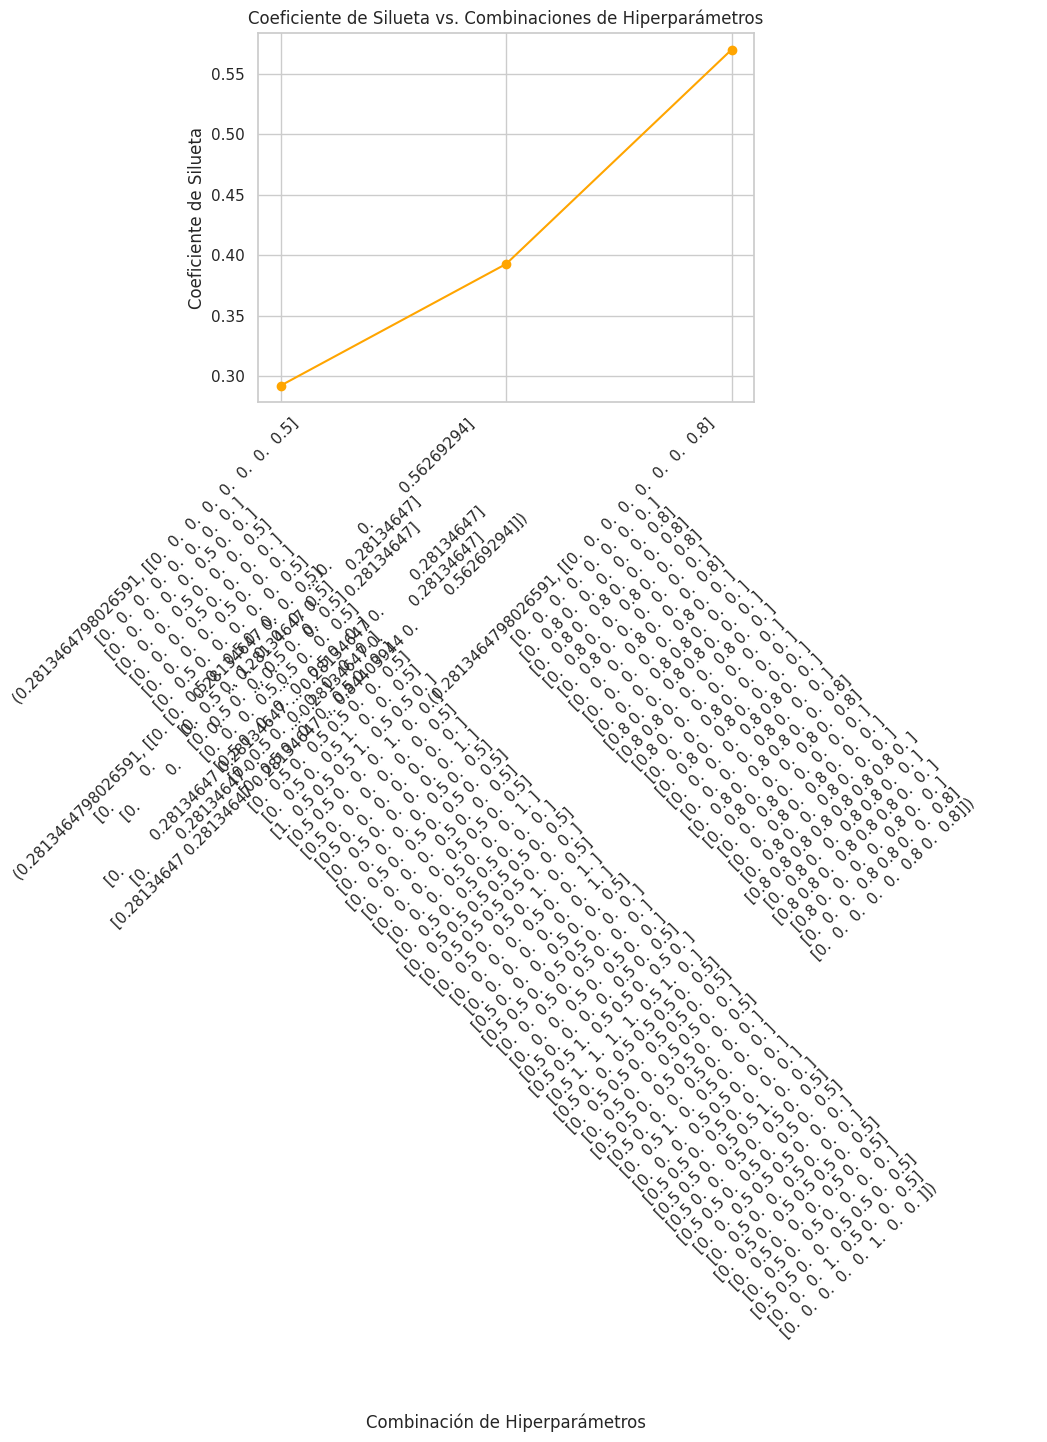

In [201]:
plt.plot(range(len(resultados_df)), silhouette_scores, marker='o', color='orange')
plt.xticks(range(len(resultados_df)), labels=[f"({row['Bandwith']}, {row['Seeds']})" for _, row in resultados_df.iterrows()], rotation=45)
plt.title('Coeficiente de Silueta vs. Combinaciones de Hiperparámetros')
plt.xlabel('Combinación de Hiperparámetros')
plt.ylabel('Coeficiente de Silueta')
plt.grid(True)
plt.show()

In [175]:
shiftProm = MeanShift(bandwidth=0.2813464798026591, seeds=semillas3).fit(datos_normalizados)
gdf['Cluster'] = shiftProm.labels_
print(gdf['Cluster'].value_counts())

Cluster
0    1259
1      28
Name: count, dtype: int64


In [176]:
import matplotlib.pyplot as plt

In [177]:
#mostrar clusters en el mapa
ax = gdf.plot("Cluster", cmap="magma", legend=True, figsize=(28, 16), categorical =True)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

Output hidden; open in https://colab.research.google.com to view.

In [178]:
ax = gdf.plot("VIVPAR_HAB", cmap="magma", legend=True, figsize=(28, 16))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

Output hidden; open in https://colab.research.google.com to view.

In [179]:
gdf.columns

Index(['CVEMA', 'MUN', 'NOM_MUN', 'AGEB', 'P12A14NOA', 'P15YM_AN', 'P18YM_PB',
       'P6A11_NOAM', 'POBTOT', 'PSINDER', 'VIVPAR_HAB', 'VPH_EXCSA',
       'VPH_LAVAD', 'VPH_NDEAED', 'VPH_PISOTI', 'VPH_REFRI', 'VPH_TELEF',
       'Rest_Carta', 'Rest_Antojitos', 'Rest_Mariscos', 'Rest_Rapida',
       'Rest_TacosTortas', 'Rest_Autoserv', 'Rest_OtrosLlevar', 'geometry',
       'Cluster'],
      dtype='object')

# CALCULANDO POBLACIÓN POR RESTAURANTE

In [180]:
total_restaurantes = ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar',
                       ]

gdf['Tot_Rest'] = gdf[total_restaurantes].sum(axis=1)

## Relación Personas por Restaurante

In [181]:
gdf['POBREST'] = gdf['POBTOT'] / gdf['Tot_Rest']
gdf.head()

,CVEMA,MUN,NOM_MUN,AGEB,P12A14NOA,P15YM_AN,P18YM_PB,P6A11_NOAM,POBTOT,PSINDER,...,Rest_Antojitos,Rest_Mariscos,Rest_Rapida,Rest_TacosTortas,Rest_Autoserv,Rest_OtrosLlevar,geometry,Cluster,Tot_Rest,POBREST
0,0061882,6,Apodaca,1882,10,67,3404,0,10712,2186,...,2,0,3,3,1,3,"POLYGON ((-100.15091 25.71505, -100.15099 25.7...",0,12,892.666667
1,0061435,6,Apodaca,1435,5,16,4582,4,9224,1185,...,0,0,1,1,3,0,"POLYGON ((-100.16946 25.75323, -100.16861 25.7...",0,5,1844.800000
2,0061647,6,Apodaca,1647,3,6,2822,0,4650,638,...,0,0,2,1,0,0,"POLYGON ((-100.23345 25.77729, -100.23349 25.7...",0,3,1550.000000
3,0060969,6,Apodaca,0969,0,0,0,0,0,0,...,2,1,3,3,6,0,"POLYGON ((-100.18562 25.77552, -100.18542 25.7...",1,23,0.000000
4,006030A,6,Apodaca,030A,10,15,2860,7,8268,1230,...,1,0,1,0,0,0,"POLYGON ((-100.16562 25.73954, -100.16554 25.7...",0,2,4134.000000


In [182]:
#mostrar Personas por restaurante
ax = gdf.plot("POBREST", cmap="magma", legend=True, figsize=(28, 16))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

Output hidden; open in https://colab.research.google.com to view.

In [183]:
#mostrar Total de restaurante
ax = gdf.plot("Tot_Rest", cmap="magma", legend=True, figsize=(28, 16))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

Output hidden; open in https://colab.research.google.com to view.

In [184]:
gdf[['Tot_Rest','POBREST','POBTOT']].describe()

,Tot_Rest,POBREST,POBTOT
count,1287.000000,1287.000000,1287.000000
mean,10.599068,1169.735322,5900.272727
std,10.603233,1395.272537,3241.195867
min,1.000000,0.000000,0.000000
25%,4.000000,364.357143,3731.000000
50%,8.000000,691.200000,5808.000000
75%,14.000000,1373.321429,7866.000000
max,151.000000,12038.000000,22586.000000


## OUTLIERS

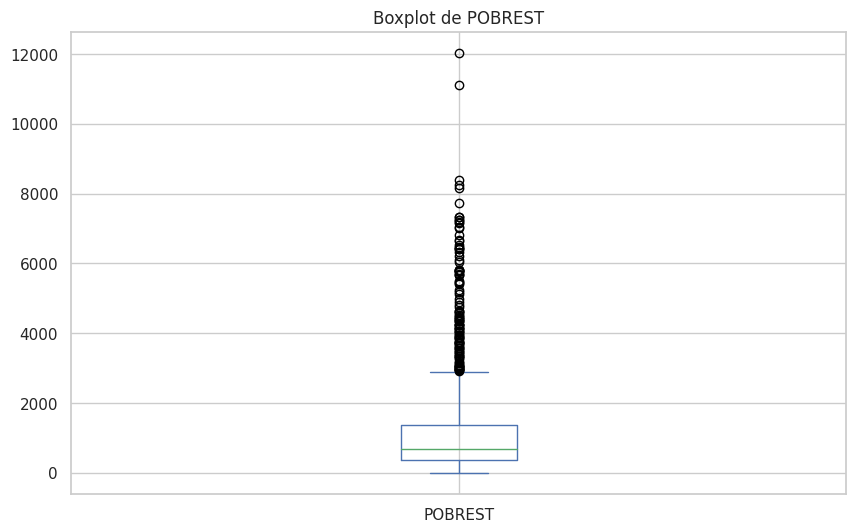

In [185]:
plt.figure(figsize=(10, 6))
gdf['POBREST'].plot(kind='box')
plt.title(f"Boxplot de {'POBREST'}")
plt.show()

A partir de este boxblot nos damos cuenta de que existen outliers que generan mucho ruido, por lo tanto, se eliminaran aquellos datos que tengan un valor mayor a 5000 en 'POBREST'.

In [186]:
# Eliminar outliers
gdf_sin_outliers = gdf[(gdf['POBREST'] < 5000)]

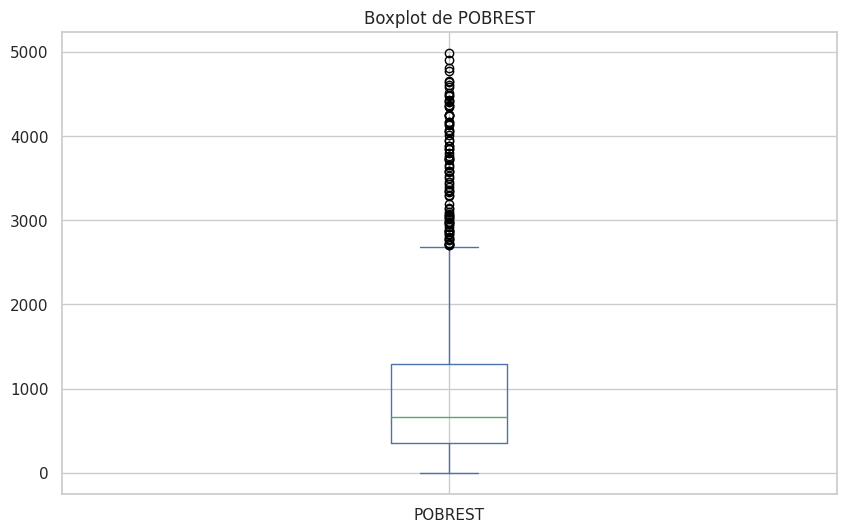

In [187]:
plt.figure(figsize=(10, 6))
gdf_sin_outliers['POBREST'].plot(kind='box')
plt.title(f"Boxplot de {'POBREST'}")
plt.show()

<ipython-input-188-a6a3e44bbc61>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gdf_sin_outliers, x='Cluster', y='POBREST', palette='magma')


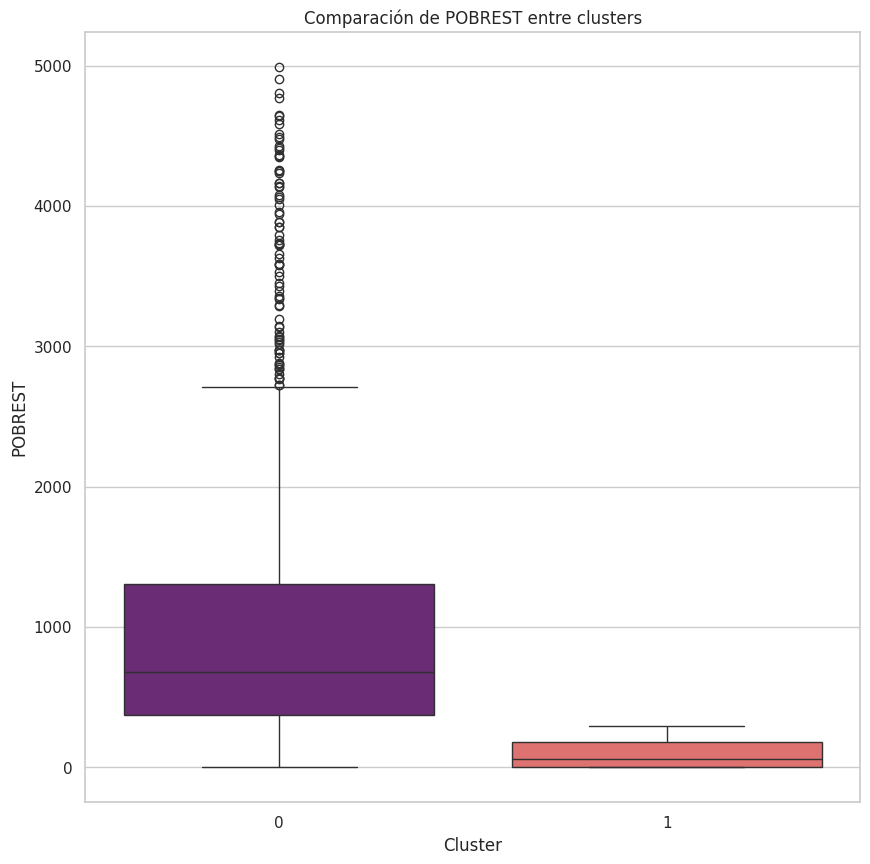

In [188]:
# Visualización de boxplots comparativos de POBREST entre clusters
plt.figure(figsize=(10, 10))
sns.boxplot(data=gdf_sin_outliers, x='Cluster', y='POBREST', palette='magma')
plt.title('Comparación de POBREST entre clusters')
plt.xlabel('Cluster')
plt.ylabel('POBREST')
plt.show()

In [189]:
#mostrar clusters en el mapa eliminando los outliers
ax = gdf_sin_outliers.plot("Cluster", cmap="magma", legend=True, figsize=(28, 16), categorical = True)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

Output hidden; open in https://colab.research.google.com to view.

In [190]:
#mostrar Relación Pob Rest eliminando los outliers
ax = gdf_sin_outliers.plot("POBREST", cmap="magma", legend=True, figsize=(28, 16))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

Output hidden; open in https://colab.research.google.com to view.

In [191]:
#conteo de clusters después de filtrar
gdf_sin_outliers['Cluster'].value_counts()

Cluster
0    1217
1      28
Name: count, dtype: int64

### Estadísticos de los clusters

In [192]:
# se seleccionan las columnas numéricas relevantes para el clustering
columnas_numericas = gdf_sin_outliers.select_dtypes(include=np.number).columns.tolist()
columnas_numericas.remove('Cluster')

# se calcula el promedio de cada variable numérica para cada cluster
medias_por_cluster = gdf_sin_outliers.groupby('Cluster')[columnas_numericas].mean()

# solo las columnas de restaurantes
columnas_restaurantes = ['Rest_Carta',
                       'Rest_Antojitos',
                       'Rest_Mariscos',
                       'Rest_Rapida',
                       'Rest_TacosTortas',
                       'Rest_Autoserv',
                       'Rest_OtrosLlevar',
                       ]
medias_restaurantes_por_cluster = medias_por_cluster[columnas_restaurantes]

# Muestra las medias de frecuencia de restaurantes por cluster
medias_restaurantes_por_cluster

,Rest_Carta,Rest_Antojitos,Rest_Mariscos,Rest_Rapida,Rest_TacosTortas,Rest_Autoserv,Rest_OtrosLlevar
Cluster,,,,,,,
0,1.419063,1.466721,0.413311,2.013969,3.868529,0.399343,0.536565
1,16.785714,4.321429,2.142857,3.464286,8.785714,7.500000,2.892857


In [193]:
medias_restaurantes_por_cluster.reset_index(inplace=True)
medias_restaurantes_melted = pd.melt(medias_restaurantes_por_cluster, id_vars=['Cluster'], var_name='Tipo de Restaurante', value_name='Frecuencia Promedio')

In [194]:
medias_restaurantes_melted['Frecuencia Promedio']

0      1.419063
1     16.785714
2      1.466721
3      4.321429
4      0.413311
5      2.142857
6      2.013969
7      3.464286
8      3.868529
9      8.785714
10     0.399343
11     7.500000
12     0.536565
13     2.892857
Name: Frecuencia Promedio, dtype: float64

In [195]:
import seaborn as sns

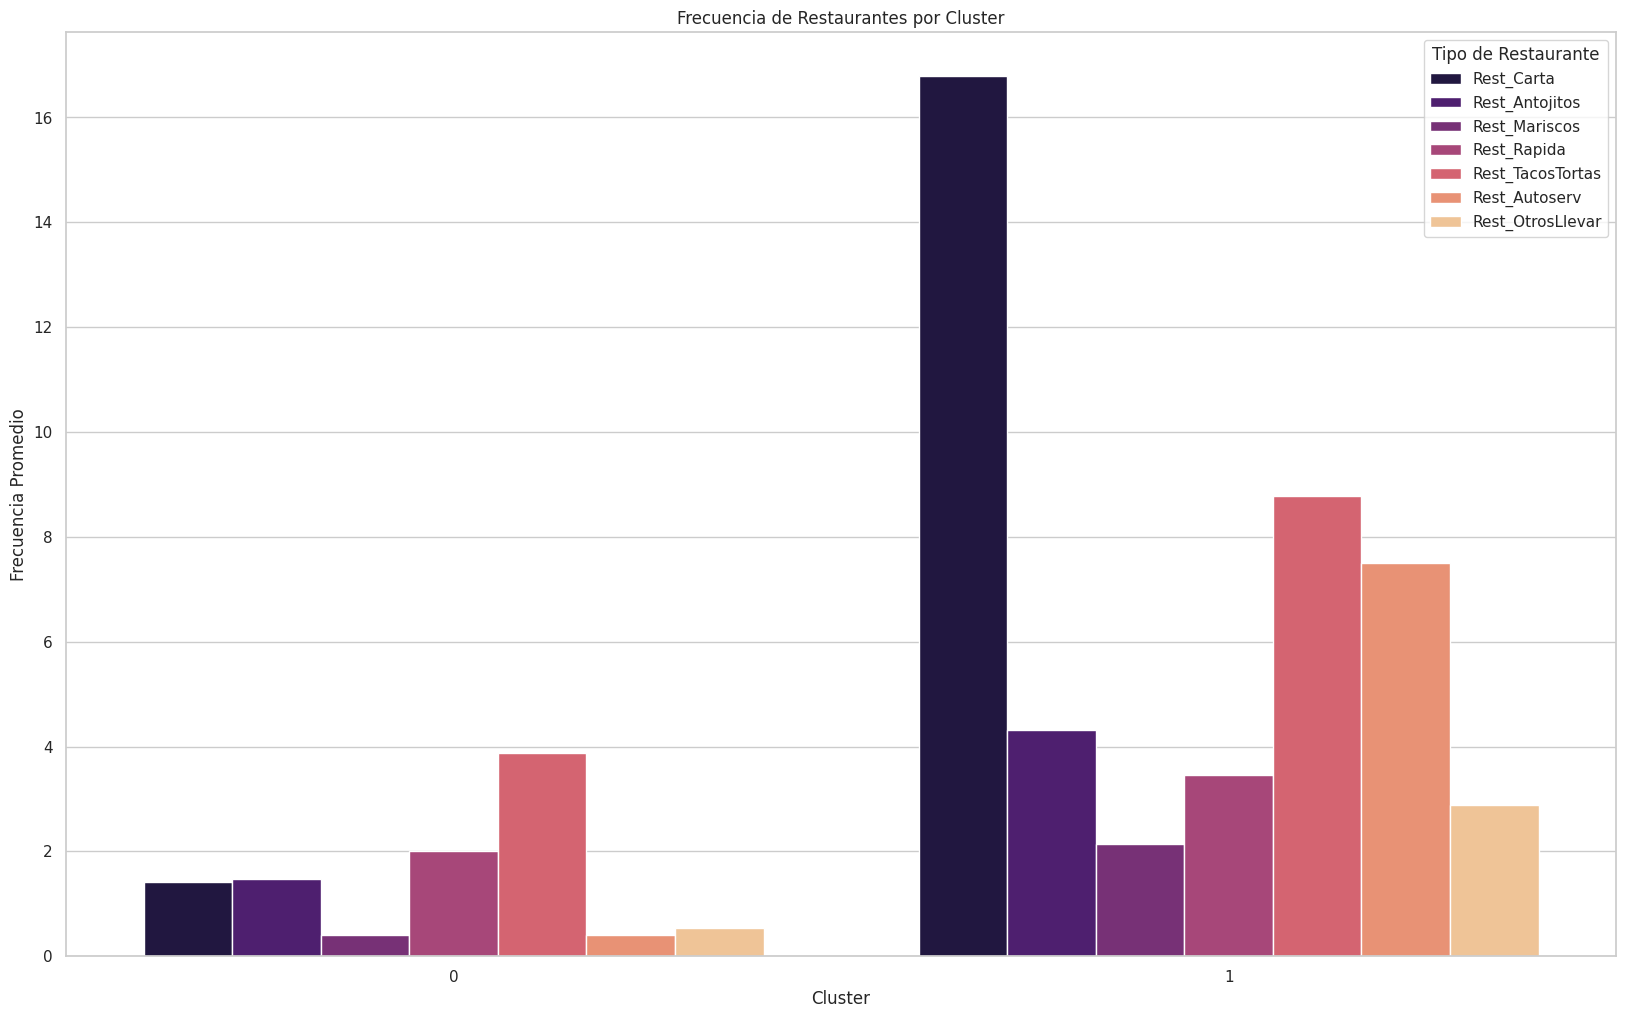

In [196]:
# Configuración de estilo de Seaborn
sns.set(style="whitegrid")

# Gráfico de barras para las medias de frecuencia de restaurantes por cluster
plt.figure(figsize=(20, 12))
sns.barplot(data=medias_restaurantes_melted,
            x='Cluster', y='Frecuencia Promedio', hue='Tipo de Restaurante', palette='magma')
plt.title('Frecuencia de Restaurantes por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frecuencia Promedio')
plt.legend(title='Tipo de Restaurante')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x
plt.show()